In [18]:
import pandas as pd, os, os.path as op, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
sns.set()




####### SET DPI HERE #######
DPI = 600 ##################
############################




u = lambda x: list(set(x))

#make necessary folders
if not op.exists('plots'):
    os.mkdir('plots')
    


In [19]:
q = pd.read_excel(op.join('data',"quest.xlsx"))
c = pd.read_excel(op.join('data',"cogn.xlsx"))
p = pd.read_excel(op.join('data',"posnerv2.xlsx"))
q = q.rename({'Participant Private ID':'id','Grupa':'group','Czy uzywa klawiatury i myszy zewnętrznej do gry lub pracy?':'keymouseuse',
         'Wiek':'age','Płec':'sex','Stan cywilny':'marital','Najwyższy ukonczony stopień edukacji':'edu',
          'Liczba ukończonych lat edukacji':'eduyears','Wielkość miasta zamieszkania':'size','Częstotliwość gry lub pracy':'pwfreq',
         'Ile pełnych lat gra lub pracuje':'pwyears','Średnia liczba godzin gry lub pracy dziennie w ostatnich 3 miesiącach':'pwhrsdaily3mo',
         'Średnia liczba godzin gry lub pracy tygodniowo w ostatnich 3 miesiącach':'pwhrsweekly3mo',
          'Czy kiedykolwiek czerpał korzyści materialne z grania w gry komputerowe?':'gainsever',
          'Czy obecnie utrzymuje się z grania w gry komputerowe?':'upkeepgamesnow',
         'Czy planuje kiedyś utrzymywać się z grania w gry komputerowe?':'upkeepgamesfuture'}, axis = 1)

c = c.rename({'Participant Private ID':'id','Zadanie':'task','Warunek':'condition',"Timed Out":'timeout'},axis=1)
c.columns = [col.lower() for col in c.columns]
p = p.rename({'Participant Private ID':'id','Zadanie':'task','Warunek':'condition',"Timed Out":'timeout',
             'Reaction Time':'rt'},axis=1)
p.columns = [col.lower() for col in p.columns]


q["group"] = q["group"].map({'Regularnie gram w League of Legends':"LoL",
                'Regularnie gram w Counter Strike: Global Offensive':"CS:GO",
                'Regularnie pracuję przy komputerze i nie gram w gry lub robię to rzadko (gry na konsole i smartfony nie są wliczane)':"Praca",
                'Regularnie pracuję lub uczę się przy komputerze i nie gram w gry lub robię to rzadko (gry na konsole i smartfony nie są wliczane)':"Praca"})

#drop columns with no variability
q = q.drop([col for col in q.columns if q[col].nunique() == 1],axis=1)


q['marital'] = q['marital'].map({'Kawaler/ panna':"Kawaler",'Żonaty/ zamężna':'Żonaty'})

#add group info to cognitive df
c["group"] = c['id'].map({pid:q[q['id'] == pid]['group'].values[0] for pid in q['id'].unique()})
p["group"] = p['id'].map({pid:q[q['id'] == pid]['group'].values[0] for pid in q['id'].unique()})
#change nans into zeros, drop trials with more attempts than possible
c['attempt'] = c['attempt'].replace({np.nan:0})
p['attempt'] = p['attempt'].replace({np.nan:0})
c = c[c['attempt'] <= 5]

c['trialtype'] = c['task'].apply(lambda x: x.split(":")[-1])
c['task'] = c['task'].apply(lambda x: x.split(":")[0])
c['task'] = c['task'].map({'Go/No-Go':'gonogo','Cued Task Switching':'cts','Posner Cueing Task':'posner','Visual Search Click on Location':'vsc'})

In [20]:
cDict = {}

for task in u([t.split(":")[0] for t in c['task'].unique()]):
    cDict[task] = c[c.task.str.contains(task)]
    
    if task == 'gonogo':
        cDict[task]['trialtype'] = cDict[task]['trialtype'].apply(lambda x: x.split()[0])
    else:
        cDict[task] = cDict[task].drop(['trialtype'],axis=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [21]:
d = p.copy()
d = d[(d['rt'] >= 100) & (d['rt'] <= 2000)]
d.loc[d["attempt"] == 0,'rt'] = np.nan
d = d.drop(['timeout','incorrect'], axis = 1)
d = d[~d.stimulus.isna()]
d['cue'] = d['cue'].apply(lambda x: x.split("Cue")[1].split('.')[0])
d['stimulus'] = d['stimulus'].apply(lambda x: x.split("Stimulus")[-1].split('.')[0])
d['congruent'] = (d['stimulus'] == d['cue']).map({True:"Congruent",False:"Incongruent"})

In [22]:
_d = d.groupby(['id']).agg(
    n = pd.NamedAgg(column='rt', aggfunc=np.size),
    rt_mean = pd.NamedAgg(column='rt', aggfunc=np.mean)
).reset_index()

pg.normality(data=_d['rt_mean']).round(3)

,W,pval,normal
rt_mean,0.679,0.0,False


#### Posner brakujące testy normalności rozkładu + test levene'a

In [24]:
pg.normality(data=desc, dv="rt_mean",group='group').round(3)

,W,pval,normal
LoL,0.960,0.172,True
Praca,0.894,0.001,False
CS:GO,0.945,0.051,True


In [25]:
pg.homoscedasticity(desc, group='group', dv='rt_mean')

,W,pval,equal_var
levene,11.251881,0.000034,False


In [26]:
pg.normality(data=correctness, dv="correct",group='group').round(3)

,W,pval,normal
LoL,0.773,0.0,False
Praca,0.703,0.0,False
CS:GO,0.744,0.0,False


### Anova w schemacie mieszanym, sprawdzamy jak grupa i zgodność bodźca ze wskazówką różnicują czas reakcji

In [5]:
desc = d.groupby(['id','group','congruent']).agg(
    n = pd.NamedAgg(column='rt', aggfunc=np.size),
    rt_mean = pd.NamedAgg(column='rt', aggfunc=np.mean)
).reset_index()

In [9]:
desc['groupXcongruent'] = desc.apply(lambda x: f"{x['group']} - {x['congruent']}",axis=1)

In [12]:
pg.normality(data=desc, dv="rt_mean",group='groupXcongruent').round(3)

,W,pval,normal
LoL - Congruent,0.996,1.000,True
LoL - Incongruent,0.924,0.118,True
Praca - Congruent,0.784,0.000,False
Praca - Incongruent,0.884,0.021,False
CS:GO - Congruent,0.875,0.015,False
CS:GO - Incongruent,0.947,0.320,True


In [26]:
pg.mixed_anova(data=desc,dv = 'rt_mean',within='congruent',between='group',subject='id').round(3)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,group,261576.949,2,57,130788.475,13.808,0.000,0.326,NaN
1,congruent,120909.215,1,57,120909.215,178.604,0.000,0.758,1.0
2,Interaction,688.649,2,57,344.325,0.509,0.604,0.018,NaN


In [27]:
pg.pairwise_ttests(data=desc,dv = 'rt_mean',within='congruent',between='group',subject='id', parametric=True, marginal=True,
            alpha=0.05, tail='two-sided', padjust='sidak', effsize='hedges', correction='auto',
                nan_policy='listwise', return_desc=True, interaction=True, within_first=True).round(3)

,Contrast,congruent,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,congruent,-,Congruent,Incongruent,310.531,89.578,374.015,78.905,True,True,-13.477,59.0,two-sided,0.000,NaN,NaN,4.359e+16,-0.747
1,group,-,LoL,Praca,302.619,24.838,407.821,110.474,False,True,-4.155,38.0,two-sided,0.000,0.001,sidak,132.324,-1.288
2,group,-,LoL,CS:GO,302.619,24.838,316.379,37.239,False,True,-1.375,38.0,two-sided,0.177,0.443,sidak,0.65,-0.426
3,group,-,Praca,CS:GO,407.821,110.474,316.379,37.239,False,True,3.508,38.0,two-sided,0.001,0.004,sidak,27.227,1.087
4,congruent * group,Congruent,LoL,Praca,272.715,22.972,377.624,126.056,False,True,-3.662,38.0,two-sided,0.001,0.005,sidak,39.101,-1.135
5,congruent * group,Congruent,LoL,CS:GO,272.715,22.972,281.253,36.794,False,True,-0.880,38.0,two-sided,0.384,0.945,sidak,0.42,-0.273
6,congruent * group,Congruent,Praca,CS:GO,377.624,126.056,281.253,36.794,False,True,3.282,38.0,two-sided,0.002,0.013,sidak,16.3,1.017
7,congruent * group,Incongruent,LoL,Praca,332.523,31.718,438.017,99.098,False,True,-4.534,38.0,two-sided,0.000,0.000,sidak,355.378,-1.405
8,congruent * group,Incongruent,LoL,CS:GO,332.523,31.718,351.505,43.004,False,True,-1.589,38.0,two-sided,0.120,0.537,sidak,0.83,-0.492
9,congruent * group,Incongruent,Praca,CS:GO,438.017,99.098,351.505,43.004,False,True,3.581,38.0,two-sided,0.001,0.006,sidak,32.345,1.110


Jest efekt zgodności bodźcow - Szybsze są triale zgodne niż niezgodne (row 0)
Jest efekt grupy - LoL i CS:GO nie różnią się od siebie, obie grupy rozwiązują szybciej od Pracy (rows 1-3)

Nie ma efektu interakcji

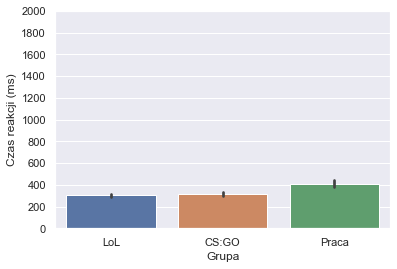

In [28]:
g = sns.barplot(data=desc,x='group',y='rt_mean',order=['LoL',"CS:GO","Praca"])
g.set(yticks=range(0,2001,200))
plt.xlabel("Grupa")
plt.ylabel("Czas reakcji (ms)")
#plt.show()
plt.savefig(op.join('plots','posner_group_rt_mean.png'),dpi = DPI,bbox_inches = "tight")
plt.show()
plt.close()

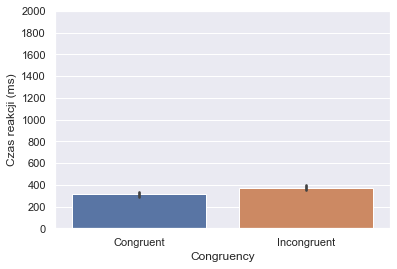

In [29]:
g = sns.barplot(data=desc,x='congruent',y='rt_mean',order=["Congruent","Incongruent"])
g.set(yticks=range(0,2001,200))
plt.xlabel("Congruency")
plt.ylabel("Czas reakcji (ms)")
plt.savefig(op.join('plots','posner_congruency_rt_mean.png'),dpi = DPI,bbox_inches = "tight")
plt.show()
plt.close()

### Anova w schemacie mieszanym, sprawdzamy jak grupa i zgodność bodźca ze wskazówką różnicują poprawność odpowiedzi

In [23]:
_c = d.groupby(['id']).agg(
    correct = pd.NamedAgg(column='correct', aggfunc=np.mean)
).reset_index()
pg.normality(data=_c['correct']).round(3)

,W,pval,normal
correct,0.744,0.0,False


In [15]:
correctness = d.groupby(['id','group','congruent']).agg(
    correct = pd.NamedAgg(column='correct', aggfunc=np.mean)
).reset_index()
correctness['groupXcongruent'] = correctness.apply(lambda x: f"{x['group']} - {x['congruent']}",axis=1)

In [16]:
pg.normality(data=correctness, dv="correct",group='groupXcongruent').round(3)

,W,pval,normal
LoL - Congruent,0.764,0.000,False
LoL - Incongruent,0.848,0.005,False
Praca - Congruent,0.763,0.000,False
Praca - Incongruent,0.900,0.042,False
CS:GO - Congruent,0.619,0.000,False
CS:GO - Incongruent,0.641,0.000,False


In [33]:
pg.mixed_anova(data=correctness,dv = 'correct',within='congruent',between='group',subject='id').round(3)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,group,0.092,2,57,0.046,6.778,0.002,0.192,NaN
1,congruent,0.576,1,57,0.576,109.281,0.000,0.657,1.0
2,Interaction,0.062,2,57,0.031,5.845,0.005,0.170,NaN


In [34]:
pg.pairwise_ttests(data=correctness,dv = 'correct',within='congruent',between='group',subject='id', parametric=True, marginal=True,
            alpha=0.05, tail='two-sided', padjust='sidak', effsize='hedges', correction='auto',
                nan_policy='listwise', return_desc=True, interaction=True, within_first=True).round(3)

,Contrast,congruent,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,congruent,-,Congruent,Incongruent,0.991,0.020,0.852,0.118,True,True,9.688,59.0,two-sided,0.000,NaN,NaN,9.146e+10,1.629
1,group,-,LoL,Praca,0.917,0.053,0.958,0.036,False,True,-2.843,38.0,two-sided,0.007,0.021,sidak,6.438,-0.881
2,group,-,LoL,CS:GO,0.917,0.053,0.890,0.078,False,True,1.255,38.0,two-sided,0.217,0.520,sidak,0.575,0.389
3,group,-,Praca,CS:GO,0.958,0.036,0.890,0.078,False,True,3.511,38.0,two-sided,0.001,0.004,sidak,27.427,1.088
4,congruent * group,Congruent,LoL,Praca,0.995,0.007,0.996,0.004,False,True,-0.910,38.0,two-sided,0.369,0.937,sidak,0.429,-0.282
5,congruent * group,Congruent,LoL,CS:GO,0.995,0.007,0.982,0.032,False,True,1.669,38.0,two-sided,0.103,0.480,sidak,0.918,0.517
6,congruent * group,Congruent,Praca,CS:GO,0.996,0.004,0.982,0.032,False,True,1.920,38.0,two-sided,0.062,0.321,sidak,1.291,0.595
7,congruent * group,Incongruent,LoL,Praca,0.839,0.108,0.920,0.071,False,True,-2.780,38.0,two-sided,0.008,0.049,sidak,5.675,-0.862
8,congruent * group,Incongruent,LoL,CS:GO,0.839,0.108,0.799,0.136,False,True,1.051,38.0,two-sided,0.300,0.882,sidak,0.478,0.326
9,congruent * group,Incongruent,Praca,CS:GO,0.920,0.071,0.799,0.136,False,True,3.523,38.0,two-sided,0.001,0.007,sidak,28.215,1.092


Jest efekt zgodności bodźcow - Poprawniej wykonywane triale zgodne niż niezgodne (row 0)
Jest efekt grupy - LoL i CS:GO nie różnią się od siebie, obie grupy rozwiązują mniej poprawnie od Pracy (rows 1-3)

Jest efekt interakcji!

W warunku congruent nie ma istotnych statystycznie różnic w poprawności odpowiedzi między grupami (rows 4-6)

W warunku incongruent LoL i CS:GO nie różnią się od siebie poprawnością odpowiedzi, pracujacy rozwiązują poprawniej od reszty

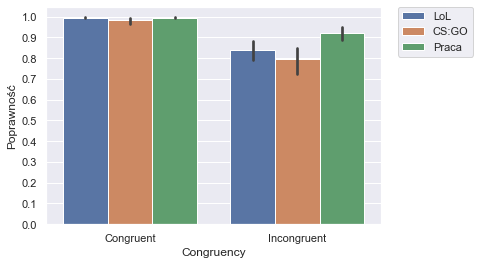

In [35]:
g = sns.barplot(data=correctness,x='congruent',y='correct',hue='group',order=["Congruent","Incongruent"],
               hue_order = ['LoL',"CS:GO","Praca"])
g.set(yticks=np.arange(0,1.1,.1))
plt.xlabel("Congruency")
plt.ylabel("Poprawność")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(op.join('plots','posner_group_congruency_correctness.png'),dpi = DPI,bbox_inches = "tight")
plt.show()
plt.close()

In [36]:
q2 = q[['id','group','pwyears','pwhrsdaily3mo','pwhrsweekly3mo']]

#### Moderacje

Moderacja => zmienne kwestionariuszowe * grupa (gracze/niegracze) a czas reakcji

In [37]:
desc2 = d.groupby(['id','group']).agg(
    n = pd.NamedAgg(column='rt', aggfunc=np.size),
    rt_mean = pd.NamedAgg(column='rt', aggfunc=np.mean)
).reset_index()

In [38]:
mod1 = pd.merge(desc2, q2)
mod1['group'] = mod1['group'].map({"LoL":1,"CS:GO":1,"Praca":0})

for v in ["pwyears","pwhrsdaily3mo","pwhrsweekly3mo"]:
    mod1[f'group_{v}'] = mod1['group']*mod1[v]


### Ile pełnych lat gra lub pracuje

In [39]:
pg.linear_regression(X = mod1[['pwyears','group','group_pwyears']], y= mod1['rt_mean'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,431.625,33.292,12.965,0.000,0.329,0.294,364.934,498.316
1,pwyears,-11.170,7.751,-1.441,0.155,0.329,0.294,-26.696,4.357
2,group,-130.081,41.841,-3.109,0.003,0.329,0.294,-213.899,-46.264
3,group_pwyears,8.996,8.836,1.018,0.313,0.329,0.294,-8.705,26.697


Nie ma efektu lat - nie przekłada się do na zmianę czasu reakcji, jest efekt grupy (ale to już wiemy z poprzednich analiz)
Nie ma efektu interakcji, czyli nie ma moderacji

### Średnia liczba godzin gry lub pracy dziennie w ostatnich 3 miesiącach

In [40]:
pg.linear_regression(X = mod1[['pwhrsdaily3mo','group','group_pwhrsdaily3mo']], y= mod1['rt_mean'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,368.710,56.818,6.489,0.000,0.304,0.267,254.889,482.531
1,pwhrsdaily3mo,3.392,8.767,0.387,0.700,0.304,0.267,-14.171,20.955
2,group,-82.365,60.613,-1.359,0.180,0.304,0.267,-203.788,39.057
3,group_pwhrsdaily3mo,-2.753,9.298,-0.296,0.768,0.304,0.267,-21.379,15.873


W ogóle nic nie ma

### Średnia liczba godzin gry lub pracy tygodniowo w ostatnich 3 miesiącach

In [41]:
pg.linear_regression(X = mod1[['pwhrsweekly3mo','group','group_pwhrsweekly3mo']], y= mod1['rt_mean'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,406.682,54.104,7.517,0.000,0.304,0.267,298.299,515.065
1,pwhrsweekly3mo,-0.523,1.590,-0.329,0.743,0.304,0.267,-3.708,2.662
2,group,-122.177,58.286,-2.096,0.041,0.304,0.267,-238.938,-5.416
3,group_pwhrsweekly3mo,0.682,1.676,0.407,0.686,0.304,0.267,-2.676,4.039


Jest tylko efekt grupy, czyli grający rozwiązują szybciej niż niegrający

In [42]:
mod2 = d.groupby(['id','group']).agg(
    correct = pd.NamedAgg(column='correct', aggfunc=np.mean)).reset_index()

mod2 = pd.merge(mod2, q2)
mod2['group'] = mod2['group'].map({"LoL":1,"CS:GO":1,"Praca":0})

for v in ["pwyears","pwhrsdaily3mo","pwhrsweekly3mo"]:
    mod2[f'group_{v}'] = mod2['group']*mod2[v]

#### Moderacja => zmienne kwestionariuszowe * grupa (gracze/niegracze) a poprawność odpowiedzi

### Ile pełnych lat gra lub pracuje

In [43]:
pg.linear_regression(X = mod2[['pwyears','group','group_pwyears']], y= mod2['correct'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.983,0.015,67.641,0.000,0.143,0.097,0.954,1.012
1,pwyears,-0.001,0.003,-0.158,0.875,0.143,0.097,-0.007,0.006
2,group,-0.032,0.018,-1.750,0.086,0.143,0.097,-0.069,0.005
3,group_pwyears,0.001,0.004,0.317,0.752,0.143,0.097,-0.007,0.009


W ogóle nic nie ma

### Średnia liczba godzin gry lub pracy dziennie w ostatnich 3 miesiącach

In [44]:
pg.linear_regression(X = mod2[['pwhrsdaily3mo','group','group_pwhrsdaily3mo']], y= mod2['correct'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.978,0.022,43.590,0.000,0.271,0.232,0.934,1.023
1,pwhrsdaily3mo,0.000,0.003,0.111,0.912,0.271,0.232,-0.007,0.007
2,group,-0.002,0.024,-0.081,0.936,0.271,0.232,-0.050,0.046
3,group_pwhrsdaily3mo,-0.004,0.004,-1.159,0.251,0.271,0.232,-0.012,0.003


W ogóle nic nie ma

### Średnia liczba godzin gry lub pracy tygodniowo w ostatnich 3 miesiącach

In [45]:
pg.linear_regression(X = mod2[['pwhrsweekly3mo','group','group_pwhrsweekly3mo']], y= mod2['correct'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.983,0.023,42.581,0.000,0.15,0.105,0.937,1.029
1,pwhrsweekly3mo,-0.000,0.001,-0.087,0.931,0.15,0.105,-0.001,0.001
2,group,-0.022,0.025,-0.887,0.379,0.15,0.105,-0.072,0.028
3,group_pwhrsweekly3mo,-0.000,0.001,-0.167,0.868,0.15,0.105,-0.002,0.001


W ogóle nic nie ma